In [13]:
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import math
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
import warnings
warnings.filterwarnings("ignore")



In [2]:
#đọc query
query_full = []
with open("query.txt") as f:
    lines = f.readlines()
    query_full = []
    for i in lines:
        query_full.append('' .join((z for z in i if not z.isdigit())).lower())

In [3]:
def numericalSort(value):
    '''
    đọc theo số thứ tự file txt
    '''
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
result = []
for i in sorted(glob.glob('./RES/*'),key=numericalSort):  #lọc chữ số
    temp = []
    with open(i) as f:
        lines = []
        read = f.readlines()
        for i in read:
            lines.append(i.split(" ")[-1].split("\t")[0])
        temp.extend(lines)
    result.append(temp)

In [5]:
def loc_chu_so(url):
    '''
    xóa các số trong văn bản
    '''
    txt = []
    for i in sorted(glob.glob(url),key=numericalSort):  #lọc chữ số
        with open(i) as f:
            lines = f.readlines()
            if len(lines) == 0: lines = " "
            char_str = ['' .join((z for z in lines[0] if not z.isdigit())).lower()]
            txt.extend(char_str)
    return txt

In [47]:
def pos(word):
    ps = PorterStemmer()
    if word == ps.stem(word): return word
    return pos(ps.stem(word))

In [48]:
def tien_xu_ly(i):
    '''
    Xóa các stopwords, đưa về từ gốc, tách từ
    '''
    tokenizer = RegexpTokenizer(r'\w+')
    ps = PorterStemmer()
    stop = set(stopwords.words("english"))

    temp = tokenizer.tokenize(i)
    output = [w for w in temp if not w in stop]
    temp_stem=[pos(word) for word in output]
    #final = [word for word in temp_stem if wordnet.synsets(word)]
  
    final_final = [word for word in temp_stem if not len(word)<3]
    return final_final

In [7]:
def make_docs(txt):
    docs = []
    for i in txt:
        docs.append(tien_xu_ly(i))
    return docs


In [49]:
def cal_precision(y_pred,y_true):
    '''
    hàm tính precision không nội suy
    sử dụng phương pháp cắt n=10
    
    '''
    pre = []
    count = 0
    for i in y_pred[0:10]:
        #print(i)
        if str(i[0]) in y_true:
            count+=1
            
    
    pre.append(count/10)
    return pre

In [9]:
def cal_recall(y_pred,y_true):
    '''
    hàm tính recall trong 10 bộ dữ liệu trả về
    
    '''
    pre = []
    count = 0
    for i in y_pred[0:10]:
        #print(i)
        if str(i[0]) in y_true:
            count+=1
            
    
    pre.append(count/len(y_true))
    return pre

In [11]:
def interpolation(y_pred,y_true):
    total = len(y_true)

    recall = [0.0]
    precision = [1.0]
    count = 0 

    for i in range (0,len(y_pred)):
     
        if str(y_pred[i].astype(int)) in y_true: 
            count +=1
            precision.append(count/(i+1))
            recall.append(count/total)

    mark = 0
    inter = []

    i = 0
    while(mark<1):
 
        if(i>= len(recall)): 
            inter.append(inter[-1])
            mark+=0.1
            continue
        if(mark<=recall[i]):
            inter.append(precision[i])
            mark+=0.1
         
        else:
            i+=1

    return inter
    

In [9]:
txt = loc_chu_so('./Cranfield/*')
docs = make_docs(txt)

# Vector Space

## Hàm

In [14]:
def make_term(txt_term):

    '''
    tạo thành các term có dạng là một dict, từ -> số lượng tài liệu chứa nó, tần số lặp từ đó trong tất cả tài liệu. Vd:
    'deepest' : {So_luong_tai_lieu: 1,
                 Tan_so: 2
                }
    '''
    words = {}
    for i in txt_term:
      
        final_final=tien_xu_ly(i)
        
        for word in final_final:
            
            if word not in words: 
                words[word] = {
                "So_luong_tai_lieu" : [txt_term.index(i)+1], 
                "Tan_so" : 1,
                "Posting": None
                }

            else:
                words[word]["Tan_so"]+=1
                current_index = txt_term.index(i)+1
                if current_index not in words[word]["So_luong_tai_lieu"]: 
                    words[word]["So_luong_tai_lieu"].append(current_index)
    for i in words:
        words[i]["So_luong_tai_lieu"] = len(words[i]["So_luong_tai_lieu"])
    return words



In [15]:
def make_detail_term(txt_term):
    '''
 
    
    '''
    words = {}
    for i in txt_term:
        final_final=tien_xu_ly(i)
        current_index = txt_term.index(i)+1
        for word in final_final:
            if (word not in words):
                words[word] = [[current_index,1,0]]
             
            else:  
                if words[word][-1][0] == current_index: words[word][-1][1] +=1 
                else: words[word].append([current_index,1,0])
            
            #print(list(words[word][0,:]))
       

    return words         


In [16]:
def make_index(term1, detail_term1):
    for word in term1:
        term1[word]["Posting"] = detail_term1[word]
    return term1 
    

In [17]:
def make_weight_for_vector(index,number):
    normal = np.zeros(number)
    for word in index:
        for i in index[word]["Posting"]:
            tf = i[1]
            idf = np.log10((number+1)/index[word]["Tan_so"])
            i[2] = tf*idf
            normal[i[0]-1] += pow((tf*idf),2)

    return index, np.sqrt(normal)

In [18]:
def normal_weight_vector(index,normal):
    for word in index:
        for i in index[word]["Posting"]:
            i[2] /= normal[i[0]-1]
    return index


In [19]:
def vector_docs(normal_weight,txt,term):
    vector_doc = []
    for i in range (0,len(txt)):
        doc_id = i+1
        vector = []
        for word in term:
            
    
            if word not in txt[i]:
                term_doc = 0
            else: 
                index = list(np.array(normal_weight[word]["Posting"])[:,0]).index(doc_id)
                term_doc = normal_weight[word]['Posting'][index][2]
            vector.append(term_doc)

            ######

            
            

        vector_doc.append(vector)
    return vector_doc

    

In [49]:
def vector_space(query,normal_weight,txt,term,vector_doc):
    query = make_term(tien_xu_ly(query))
    
    relevance_scores = {}
    for i in range (0,len(txt)):
        doc_id = i+1
        vector_query = np.zeros(len(term))
        
        for word in query:
            if word not in term: continue
            count = query[word]['Tan_so']
            index = list(term).index(word)
            vector_query[index] = count * np.log10((len(txt)+1)/term[word]["Tan_so"])

        score = cosine_similarity(np.array(vector_query).reshape(1,-1),np.array(vector_doc[i]).reshape(1,-1))
        if (score<=0): continue
        relevance_scores[doc_id] =score
    sorted_value = sorted(relevance_scores.items(), key=lambda x: x[1], reverse = True)
    return sorted_value
    

## Main

In [22]:
term = make_term(txt)
detail_term = make_detail_term(txt)

In [25]:
index = make_index(term,detail_term)

In [26]:
not_normal, normal = make_weight_for_vector(term,len(txt))
normal_weight = normal_weight_vector(not_normal,normal)

In [27]:
vector_doc = vector_docs(normal_weight,docs,term)

## Đánh giá

In [28]:
score_vp_recall = []
score_vp_pre = []
score_inter = []
for i in range (0,len(query_full)):
    y_sp = vector_space(query_full[i],normal_weight,docs,term,vector_doc)
    score_vp_pre.append(cal_precision(y_sp,result[i]))
    score_vp_recall.append(cal_recall(y_sp,result[i]))
    score_inter.append(interpolation(np.array(y_sp)[:,0],result[i]))

### Precision

In [29]:
np.mean(score_vp_pre)

0.2662222222222222

### Recall

In [30]:
np.mean(score_vp_recall)

0.38802542942047935

### MAP

In [31]:
map = []
for i in range(0,11):
    map.append(np.mean(np.array(score_inter)[:,i]))

In [28]:
width = 0.2
fig = plt.figure(figsize = (15, 10))
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.plot(np.arange(len(map)),map,marker = 'o')

plt.yticks([[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]])
plt.xticks([r + width for r in range(len(map))],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 1080x720 with 1 Axes>

# BIM

## Hàm

In [13]:
def make_term_bim(txt_term):

    '''
    tạo thành các term có dạng là một dict, từ -> số lượng tài liệu chứa nó, tần số lặp từ đó trong tất cả tài liệu. Vd:
    'deepest' : {So_luong_tai_lieu: 1,
                 Tan_so: 2
                }
    '''
    words = {}
    for i in txt_term:
      
        final_final=tien_xu_ly(i)
        
        for word in final_final:
            
            if word not in words: 
                words[word] = {
                "So_luong_tai_lieu" : [txt_term.index(i)+1], 
                "Tan_so" : 1,
                "Posting": None,
                "Weight" : None
                }

            else:
                words[word]["Tan_so"]+=1
                current_index = txt_term.index(i)+1
                if current_index not in words[word]["So_luong_tai_lieu"]: 
                    words[word]["So_luong_tai_lieu"].append(current_index)
    for i in words:
        words[i]["So_luong_tai_lieu"] = len(words[i]["So_luong_tai_lieu"])
    return words

In [15]:
def make_detail_term(txt_term):
    '''
    Chi tiết về term đó, từ -> số Id docs: số lần lặp trong doc đó. Vd
    conceived: {
                [1016, 1]
                [1268, 1]
    }
    
    '''
    words = {}
    for i in txt_term:
        final_final=tien_xu_ly(i)
        current_index = txt_term.index(i)+1
        for word in final_final:
            if (word not in words):
                words[word] = [[current_index,1,0]]
             
            else:  
                if words[word][-1][0] == current_index: words[word][-1][1] +=1 
                else: words[word].append([current_index,1,0])
            
            #print(list(words[word][0,:]))
       

    return words    

In [16]:
def bim1(term,txt):
    '''
    trường hợp 1 chưa có thông tin
    '''
    weights = {}

    for word in term:
        p = 0.5
        p_= term[word]['So_luong_tai_lieu']/(len(txt))
        #w = np.log2(p/p_)
        w = p/p_
        weights[word] = w


    return weights

In [17]:
def make_index(term1, detail_term1,weight):
    for word in term1:
        term1[word]["Posting"] = detail_term1[word]
        term1[word]["Weight"] = weight[word]
    return term1 

In [35]:
def update(term,query,docs_relevant,txt):
    '''
    docs_relevant: tập các văn bản liên quan 
    Rt: số tài liệu liên quan đến term
    Nr: số tài liệu liên quan
    p = (Rt+0.5) / (Nr+1)
    p- = (Nt-Rt + 0.5)/(N-Nr + 1)
    '''
    query = make_term_bim(tien_xu_ly(query))
    Nr = len(docs_relevant)
    for word in query:
        id = []
        id.append(count for count in docs_relevant if count in np.array(term[word]["Posting"])[:,0])
        Rt = len(id)
        p = (Rt+0.5) / (Nr+1)
        p_ = (term[word]["So_luong_tai_lieu"]-Rt + 0.5)/(len(txt)-Nr + 1)
        term[word]["Weight"] = p / p_

In [19]:
def relevant_bim(term,query,txt):
    relevance_scores = {}
    doc_id = 0
    query = make_term_bim(tien_xu_ly(query))
    for i in range (0,len(txt)):
        doc_id = i+1
        score = -1
        for word in query:
            if word in txt[i]:
                if score == -1: score = 1
           
                score *= term[word]["Weight"]
                
        if(score==-1): continue
        relevance_scores[doc_id] = score
    sorted_value = sorted(relevance_scores.items(), key=lambda x: x[1], reverse = True)
    return sorted_value

## Main

In [39]:
term = make_term_bim(txt)
detail_term = make_detail_term(txt)
weight = bim1(term,txt)
index= make_index(term,detail_term,weight)

## Đánh giá

In [83]:
score_bim_pre = []
score_bim_recall = []
score_bim_inter = []
for i in range (0,len(query_full)):
    y_bim = relevant_bim(term,query_full[i],docs)
    score_bim_pre.append(cal_precision(y_bim,result[i]))
    score_bim_recall.append(cal_recall(y_bim,result[i]))
    score_bim_inter.append(interpolation(np.array(y_bim)[:,0],result[i]))



### Precision

In [84]:
np.mean(score_bim_pre)

0.2497777777777778

### Recall

In [85]:
np.mean(score_bim_recall)

0.37159532548779545

### MAP

In [86]:
map = []
for i in range(0,11):
    map.append(np.mean(np.array(score_bim_inter)[:,i]))

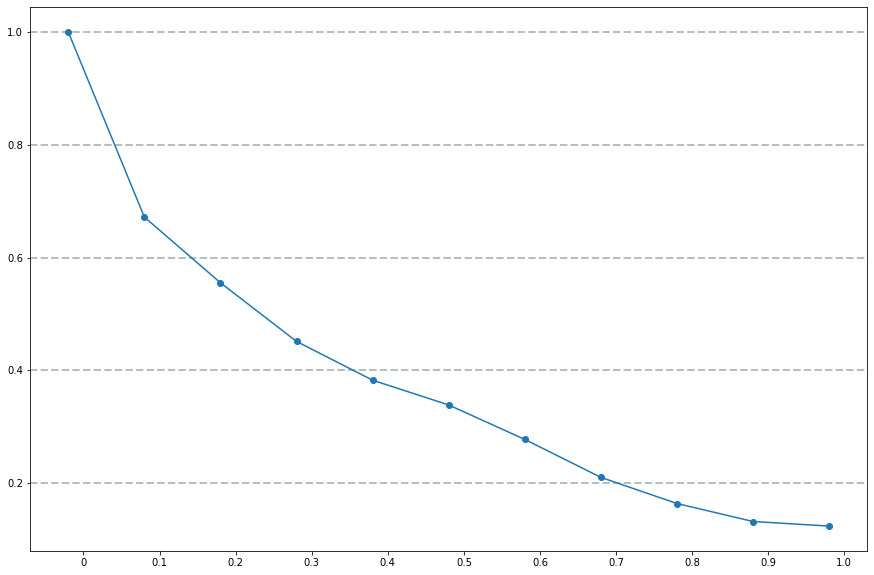

In [87]:
width = 0.2
fig = plt.figure(figsize = (15, 10))
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.plot(np.arange(len(map)),map,marker = 'o')

plt.xticks([r + width for r in range(len(map))],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

# Test với thư viện

In [20]:
D = txt

In [22]:
from whoosh.index import create_in
from whoosh.fields import *
from whoosh.analysis import StandardAnalyzer

schema = Schema(docid=STORED(), content=TEXT(stored=True, analyzer=StandardAnalyzer()))
ix = create_in("ind", schema)
writer = ix.writer()
for i in range(len(D)):
  writer.add_document(docid="{}".format(i+1), content=D[i])
writer.commit()


In [23]:
from whoosh import qparser
from whoosh import scoring
import whoosh.index as index

ind = index.open_dir("ind")
searcher = ind.searcher(weighting=scoring.TF_IDF())

parser = qparser.QueryParser("content", ind.schema, group=qparser.OrGroup)
score_wh_pre = []
score_wh_recall = []
score_wh_inter = []
for q in range (0,len(query_full)):
  query = parser.parse(query_full[q])
  results = searcher.search(query, limit=None)
  y_wh = []
  for i in range(len(results)):
    y_wh.append([results[i]['docid']])



  score_wh_pre.append(cal_precision(y_wh,result[q]))
  score_wh_recall.append(cal_recall(y_wh,result[q]))

  score_wh_inter.append(interpolation(np.array(y_wh)[:,0],result[q]))

 

In [24]:
np.mean(score_wh_pre)

0.20622222222222225

In [25]:
np.mean(score_wh_recall)

0.2955906669884002

In [30]:
map = []
for i in range(0,11):
    map.append(np.mean(np.array(score_wh_inter)[:,i]))

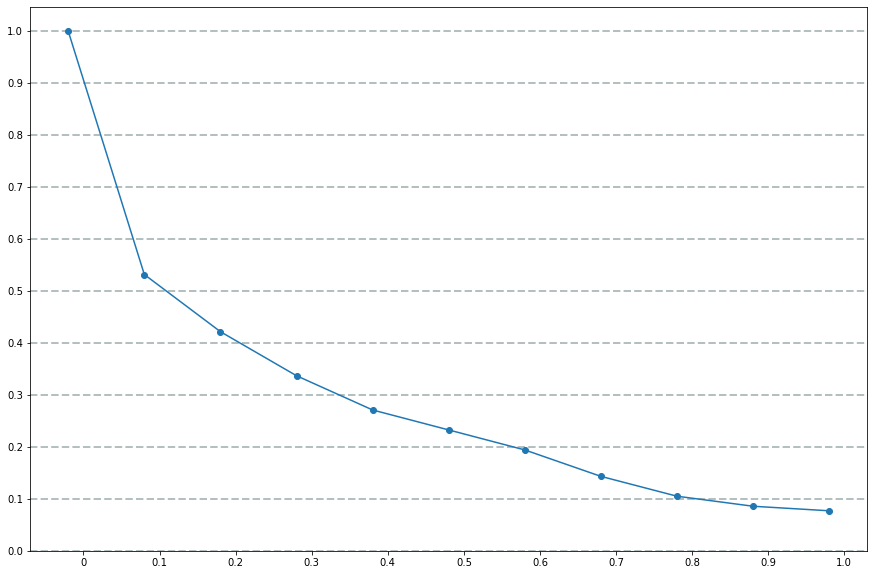

In [33]:
width = 0.2
fig = plt.figure(figsize = (15, 10))
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.plot(np.arange(len(map)),map,marker = 'o')
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xticks([r + width for r in range(len(map))],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()